In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
from glob import glob
from dask import bag
from PIL import Image, ImageDraw
import tensorflow as tf
from tqdm import tqdm
from tensorflow.python.framework import ops
import math

%matplotlib inline

In [2]:
fnames = glob('/home/ubuntu/kaggle/data/*.csv')
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

#rename the file, replacing space
classfiles = os.listdir('/home/ubuntu/kaggle/data')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)}

In [3]:
#convert stroke to image
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

In [4]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape = (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape = (None, n_y))
    return X, Y

In [54]:
def initialize_parameters():
    tf.set_random_seed(1)                             
    W1 = tf.get_variable("W1", [2, 2, 1, 4], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 4, 8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3} 
    return parameters

In [6]:
def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding="SAME") # 32*32*64
    # RELU
    A1 = tf.nn.relu(Z1) 
    # MAXPOOL: window 2x2, sride 2, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME") # 16*16*64 
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding="SAME") # 16*16*128
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME") # 8*8*128
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P2, W3, strides=[1, 1, 1, 1], padding="SAME") # 
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P3 = tf.nn.max_pool(A3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
    # FLATTEN
    P3 = tf.contrib.layers.flatten(P3)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 10 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z4 = tf.contrib.layers.fully_connected(P3, num_outputs = 10, activation_fn = None)
    ### END CODE HERE ###

    return Z4

In [7]:
def compute_cost(Z4, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z4, labels=Y))    
    return cost

In [8]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)
    m = X.shape[0]
    n_y = Y.shape[1]
    mini_batches = []
    
    #shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :].reshape((m, n_y))
    
    #partition
    num_complete_minibatches = int(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [9]:
def shuffle(X, seed=0):
    np.random.seed(seed)
    m = X.shape[0]
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    return shuffled_X

In [37]:
def model(X_train, Y_train, val_frac=0.05, learning_rate = 0.009,
          num_epochs = 50, minibatch_size = 256, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent(tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    X_val = X_train[0 : int(val_frac * m), :, :, :]
    X_train_t = X_train[int(val_frac * m) : m, :, :, :]
   
    Y_val = Y_train[0 : int(val_frac * m), :]
    Y_train_t = Y_train[int(val_frac * m) : m, :]
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z4 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z4, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    n = 0
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m * (1-val_frac) / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train_t, Y_train_t, minibatch_size, seed)

            for minibatch in minibatches:
                minibatch_cost = 0

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)                
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('number of epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.ylim((0, 0.015))
        plt.show()

        #Calculate the correct predictions
        predict_op = tf.argmax(Z4, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        #Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        
        train_accuracy = accuracy.eval({X: X_train_t, Y: Y_train_t})
        test_accuracy = accuracy.eval({X: X_val, Y: Y_val})

        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [38]:
def convert_to_one_hot(Y, C):
    n_y = Y.shape[0]
    hot = np.zeros((n_y, C))
    Y = Y.astype(np.int64)
    hot[np.arange(n_y), Y] = 1
    return hot

In [39]:
num_classes = 10
imheight, imwidth = 32, 32  
ims_per_class = 2000
train_grand = []

for i,c in enumerate(fnames[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4) #unrecognized will be filtered out
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i) # labeling
    trainarray = np.concatenate((labelarray, trainarray), axis=1) #first col is label
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

In [40]:
shuffled_train = shuffle(train_grand, seed=0)

X_train = shuffled_train[:, 1 : train_grand.shape[1]]
X_train = X_train.reshape(-1, imheight, imwidth, 1)

Y_train = shuffled_train[:, 0]
Y_train = convert_to_one_hot(Y_train, 10)

Cost after epoch 0: 0.005691
Cost after epoch 5: 0.002758
Cost after epoch 10: 0.004703
Cost after epoch 15: 0.004650
Cost after epoch 20: 0.004036
Cost after epoch 25: 0.002949
Cost after epoch 30: 0.004605
Cost after epoch 35: 0.002511
Cost after epoch 40: 0.003141
Cost after epoch 45: 0.002936


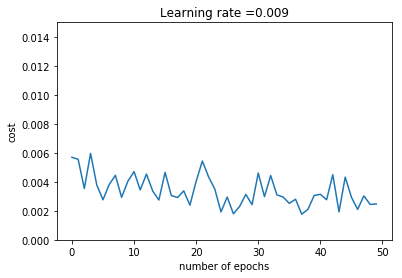

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.8556316
Test Accuracy: 0.8


In [56]:
_, _, parameters = model(X_train, Y_train, val_frac=0.05, learning_rate = 0.009,
          num_epochs = 50, minibatch_size = 128, print_cost = True)